# Mortality numbers on the ICU and in hospital of adult patients
This notebook consists of two queries that are related in topic. First, we are interested in the mortality numbers of all adult patients on the ICU. Next, we would like to know the mortality numbers in hospital.

## 1. Mortality numbers on the ICU across care units
We would like to know the mortality numbers of adult patients who were admitted to the ICU, and the distribution of these mortality numbers across the different ICUs. If a patient’s death was registered while the patient was on the ICU, or 6 hours before being admitted to, or 6 hours after leaving the ICU, we assume that the patient has died on the ICU. 

### SQL query description
The following diagram visualizes the SQL query that is needed to obtain the ICU mortality numbers. We combine the Patients and Icustays tables based on the subject identifier, and select each patient’s date of birth and date of death, and the care unit and admission time corresponding to each ICU stay. The admission time and date of death together indicate whether or not a patient died on the ICU. The age (age >= 16) is again combined from the admission time and date of birth.

In [1]:
# Imports:
import numpy as np
import pandas as pd
import sys
import psycopg2
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mc
import colorsys


In [2]:
# Configuration:
sqluser = 'colin'
dbname = 'mimiciii'
password=''
schema_name = 'mimiciii'

# Connect to MIMIC-III:
con = psycopg2.connect(host="192.168.178.30", dbname=dbname, user=sqluser, password=password)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

/tmp/ipykernel_2067177/1298861887.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  query_output = pd.read_sql_query(query,con)
/tmp/ipykernel_2067177/1298861887.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap("viridis_r")


Total mortality numbers:  icu_expire_flag
0    48858
1     4565
Name: icu_expire_flag, dtype: int64

Mortality numbers per intensive care unit: 
first_careunit  icu_expire_flag
CCU             0                   7041
                1                    685
CSRU            0                   9010
                1                    301
MICU            0                  18865
                1                   2222
SICU            0                   8078
                1                    813
TSICU           0                   5864
                1                    544
Name: icu_expire_flag, dtype: int64
Percentages mortality (% of total admissions):  icu_expire_flag
0    91.454991
1     8.545009
Name: icu_expire_flag, dtype: float64

Percentages mortality per intensive care unit: 
first_careunit  icu_expire_flag
CCU             0                  91.133834
                1                   8.866166
CSRU            0                  96.767265
                1            

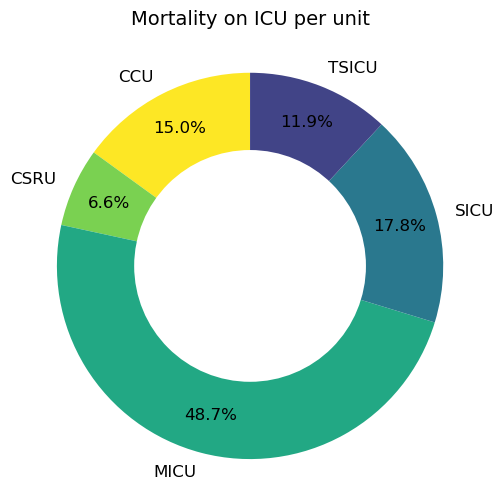

In [3]:
query = \
"""
SELECT i.first_careunit, 
round((EXTRACT(EPOCH FROM (i.intime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) as age,
CASE WHEN p.dod IS NOT NULL 
     AND p.dod >= i.intime - interval '6 hour'
     AND p.dod <= i.outtime + interval '6 hour' THEN 1 
     ELSE 0 END AS icu_expire_flag
FROM mimiciii.patients p
INNER JOIN mimiciii.icustays i ON p.subject_id = i.subject_id
WHERE round((EXTRACT(EPOCH FROM (i.intime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) >= 16;
"""

query_output = pd.read_sql_query(query,con)
print('Total mortality numbers: ', query_output.groupby('icu_expire_flag').icu_expire_flag.count())
print('\nMortality numbers per intensive care unit: ')
print(query_output.groupby(['first_careunit', 'icu_expire_flag']).icu_expire_flag.count())

# Or in percentages:
print('Percentages mortality (% of total admissions): ',  query_output.groupby('icu_expire_flag').icu_expire_flag.count() / 
     query_output.icu_expire_flag.count() * 100)
print('\nPercentages mortality per intensive care unit: ')
print(query_output.groupby(['first_careunit', 'icu_expire_flag']).icu_expire_flag.count() / 
     query_output.groupby('first_careunit').icu_expire_flag.count() * 100)

# Visualize with a piechart:
care_units = ['CCU', 'CSRU', 'MICU', 'SICU', 'TSICU']
total = 0.0
percentages = []
for c in care_units:
    percentages.append(query_output.loc[(query_output['first_careunit'] == c) & (query_output['icu_expire_flag'] == 1)].shape[0])
    total += percentages[-1]
total = len(care_units) * [total]
percentages = np.array(percentages) / np.array(total) * 100

care_units = ['CCU', 'CSRU', 'MICU', 'SICU', 'TSICU']
colors = cm.get_cmap("viridis_r")
colors = colors(np.arange(5)/5.)
fig1, ax1 = plt.subplots(figsize=(5, 5))
patches, texts, autotexts = ax1.pie(percentages, labels = care_units, autopct = '%1.1f%%', startangle = 90, 
                                    colors = colors, pctdistance = 0.8)
for i in range(len(texts)):
    texts[i].set_fontsize('large')
    texts[i].set_fontweight('roman')
    autotexts[i].set_fontsize('large')
centre_circle = plt.Circle((0,0),0.60,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Mortality on ICU per unit\n', fontsize='14', fontweight='roman')
ax1.axis('equal')
fig1.tight_layout()
fig1.savefig('mortality_ICU_piechart.jpg', dpi=400)

## 2. Mortality numbers in hospital across care units
We would also like to know the mortality numbers of adult patients who were admitted to hospital, and the distribution of those numbers across different ICUs. In this case, there is a variable called ‘hospital_expire_flag’ in the Admissions table that defines if a patient has died in hospital.

### SQL query description
The Patients and Icustays tables are combined based on the subject’s unique identifier, and the Admissions table is also joined based on the hospital admission’s identifier. We will need to select the hospital admission’s identifier, care unit, admission time and ‘hospital_expire_flag’. We also need the date of birth to obtain the age (age >= 16). 

### Implementation of the above query

/tmp/ipykernel_2067177/4237952266.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  query_output = pd.read_sql_query(query,con)


Total hospital mortality numbers:  hospital_expire_flag
0    44037
1     5748
Name: hospital_expire_flag, dtype: int64

Hospital mortality numbers per intensive care unit: 
first_careunit  hospital_expire_flag
CCU             0                        6441
                1                         816
CSRU            0                        8278
                1                         363
MICU            0                       16909
                1                        2860
SICU            0                        7091
                1                        1020
TSICU           0                        5318
                1                         689
Name: hospital_expire_flag, dtype: int64
Percentages mortality (% of total admissions):  hospital_expire_flag
0    88.454354
1    11.545646
Name: hospital_expire_flag, dtype: float64

Percentages mortality per intensive care unit: 
first_careunit  hospital_expire_flag
CCU             0                       88.755684
           

/tmp/ipykernel_2067177/4237952266.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors=cm.get_cmap("viridis_r")


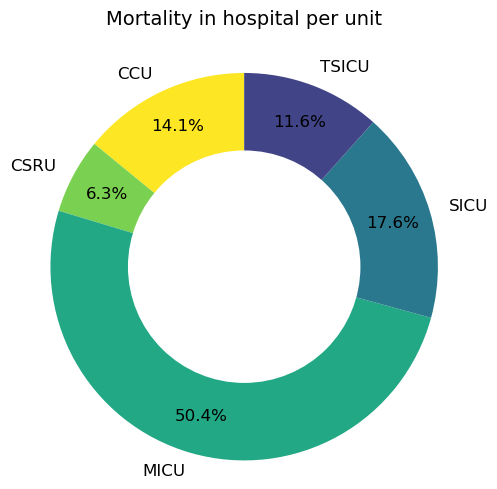

In [4]:
query = \
"""
SELECT i.hadm_id, i.first_careunit, a.hospital_expire_flag,
round((EXTRACT(EPOCH FROM (a.admittime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) as age
FROM mimiciii.patients p
INNER JOIN mimiciii.icustays i ON p.subject_id = i.subject_id
INNER JOIN mimiciii.admissions a ON i.hadm_id = a.hadm_id
WHERE round((EXTRACT(EPOCH FROM (a.admittime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) >= 16;
"""

query_output = pd.read_sql_query(query,con)
query_output.head()
print('Total hospital mortality numbers: ', query_output.drop_duplicates(['hadm_id']).groupby('hospital_expire_flag')
      .hospital_expire_flag.count())
print('\nHospital mortality numbers per intensive care unit: ')
print(query_output.drop_duplicates(['hadm_id']).groupby(['first_careunit', 'hospital_expire_flag'])
      .hospital_expire_flag.count())

# Or in percentages:
print('Percentages mortality (% of total admissions): ', query_output.drop_duplicates(['hadm_id'])
      .groupby('hospital_expire_flag').hospital_expire_flag.count() / query_output.drop_duplicates(['hadm_id'])
      .hospital_expire_flag.count() * 100)
print('\nPercentages mortality per intensive care unit: ')
print(query_output.drop_duplicates(['hadm_id']).groupby(['first_careunit', 'hospital_expire_flag'])
      .hospital_expire_flag.count() / query_output.drop_duplicates(['hadm_id']).groupby('first_careunit')
      .hospital_expire_flag.count() * 100)

# Visualize with a piechart:
care_units = ['CCU', 'CSRU', 'MICU', 'SICU', 'TSICU']
total = 0.0
percentages = []
for c in care_units:
    percentages.append(query_output.loc[(query_output['first_careunit'] == c) & (query_output['hospital_expire_flag'] == 1)].shape[0])
    total += percentages[-1]
total = len(care_units) * [total]
percentages = np.array(percentages) / np.array(total) * 100

care_units = ['CCU', 'CSRU', 'MICU', 'SICU', 'TSICU']
colors=cm.get_cmap("viridis_r")
colors = colors(np.arange(5)/5.)
fig1, ax1 = plt.subplots(figsize=(5, 5))
patches, texts, autotexts = ax1.pie(percentages, labels = care_units, autopct = '%1.1f%%', startangle = 90, 
                                    colors = colors, pctdistance = 0.8)
for i in range(len(texts)):
    texts[i].set_fontsize('large')
    texts[i].set_fontweight('roman')
    autotexts[i].set_fontsize('large')
centre_circle = plt.Circle((0,0),0.60,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Mortality in hospital per unit\n', fontsize='14', fontweight='roman')
ax1.axis('equal')
fig1.tight_layout()
fig1.savefig('mortality_hospital_piechart.jpg', dpi=400)